In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Parameters for the Vicsek model
N = 150  # number of birds
L = 100  # size of the domain

eta = 0.5  # noise
v = 10  # velocity of birds
dt = 0.5    # time step
R = 5     # radius of interaction
Nt = 100  # number of time steps

# Parameters for drones
Nd = 5  # number of drones
vd = 10  # constant speed of drones
Rd = 5  # range of influence of drones
# Additional array to keep track of which drone each bird is following
# -1 indicates that the bird is not following any drone
stuck_birds = set()

flock_sizes = []


# Initialize birds
def initialize_birds(N, L):
    x = np.random.rand(N) * L
    y = np.random.rand(N) * L
    theta = np.random.rand(N) * 2 * np.pi
    vx = v * np.cos(theta)
    vy = v * np.sin(theta)
    return x, y, vx, vy, theta

# Initialize drones
def initialize_drones(Nd, L):
    x = np.random.rand(Nd) * L
    y = np.random.rand(Nd) * L
    theta = np.random.rand(Nd) * 2 * np.pi
    vx = vd * np.cos(theta)
    vy = vd * np.sin(theta)
    return x, y, vx, vy

def update(x, y, vx, vy, theta, drone_x, drone_y, drone_vx, drone_vy, Rsq, eta, N, dt, stuck_birds):
    for i in range(N):
        if i not in stuck_birds:
            # Calculate distance to each drone
            dx = drone_x - x[i]
            dy = drone_y - y[i]
            dist_sq = dx**2 + dy**2

            # Check if any drone is within influence range
            within_range = dist_sq < Rd**2
            if np.any(within_range):
                # Attract birds towards the closest drone and match drone speed
                closest_drone = np.argmin(dist_sq)
                stuck_birds.add(i)  # Mark this bird as 'stuck' to a drone
                vx[i] = drone_vx[closest_drone]
                vy[i] = drone_vy[closest_drone]
            else:
                # Vicsek model update
                within_radius = (x - x[i])**2 + (y - y[i])**2 < Rsq
                theta[i] = np.arctan2(vy[within_radius].mean(), vx[within_radius].mean()) + eta * (np.random.rand() - 0.5)
                vx[i] = v * np.cos(theta[i])
                vy[i] = v * np.sin(theta[i])
        else:
            # If the bird is 'stuck', it keeps moving with its assigned drone's velocity
            closest_drone = np.argmin((drone_x - x[i])**2 + (drone_y - y[i])**2)
            vx[i] = drone_vx[closest_drone]
            vy[i] = drone_vy[closest_drone]

    # Update positions
    x += vx * dt
    y += vy * dt

    # Apply periodic boundary conditions
    x = x % L
    y = y % L

    return x, y, vx, vy, stuck_birds


def update_drones(drone_x, drone_y, drone_vx, drone_vy, L, vd, dt):
    # Move drones straight ahead
    drone_x += drone_vx * dt
    drone_y += drone_vy * dt

    # Check for proximity and pass each other without changing direction
    for i in range(Nd):
        for j in range(i + 1, Nd):
            dx = drone_x[i] - drone_x[j]
            dy = drone_y[i] - drone_y[j]
            dist = np.sqrt(dx**2 + dy**2)
            if dist < Rd:  # If drones are too close
                # Adjust their positions slightly to avoid overlap without changing direction
                drone_x[i] += drone_vx[i] * dt
                drone_y[i] += drone_vy[i] * dt
                drone_x[j] += drone_vx[j] * dt
                drone_y[j] += drone_vy[j] * dt

    # Apply periodic boundary conditions
    drone_x = drone_x % L
    drone_y = drone_y % L

    return drone_x, drone_y, drone_vx, drone_vy


def calculate_flock_size(bird_positions, R):
    # If there are no birds, return 0
    if len(bird_positions) == 0:
        return 0
    
    # Initialize a counter for the total number of birds within range
    total_birds_within_range = 0

    # Loop over all pairs of birds
    for i in range(len(bird_positions)):
        for j in range(i+1, len(bird_positions)):
            # Calculate the distance between the two birds
            distance = np.sqrt((bird_positions[i][0] - bird_positions[j][0])**2 + 
                               (bird_positions[i][1] - bird_positions[j][1])**2)
            
            # If the distance is less than or equal to the specified range, increment the counter
            if distance <= R:
                total_birds_within_range += 1

    # Calculate the average number of birds within range
    average_flock_size = total_birds_within_range / len(bird_positions)

    return average_flock_size




# Visualization function
def visualize(x, y, vx, vy, drone_x, drone_y):
    plt.figure(figsize=(8, 8))

    # Plot birds as smaller arrows
    plt.quiver(x, y, vx, vy, color='black', scale=200, headwidth=5, headlength=5)

    # Plot drones as red diamonds
    plt.scatter(drone_x, drone_y, c='red', marker='D', label='Drones')

    plt.xlim(0, L)
    plt.ylim(0, L)
    plt.title("Birds and Drones Interaction")
    plt.legend()
    plt.show()



# Simulation
x, y, vx, vy, theta = initialize_birds(N, L)
drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

for _ in range(Nt):
    drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, L, vd, dt)
    x, y, vx, vy, stuck_birds = update(x, y, vx, vy, theta, drone_x, drone_y, drone_vx, drone_vy, R**2, eta, N, dt, stuck_birds)
    
    # Calculate the flock size
    flock_size = calculate_flock_size(list(zip(x, y)), R)
    flock_sizes.append(flock_size)
    
    
    
    visualize(x, y, vx, vy, drone_x, drone_y)
    clear_output(wait=True)




KeyboardInterrupt: 

<Figure size 800x800 with 0 Axes>

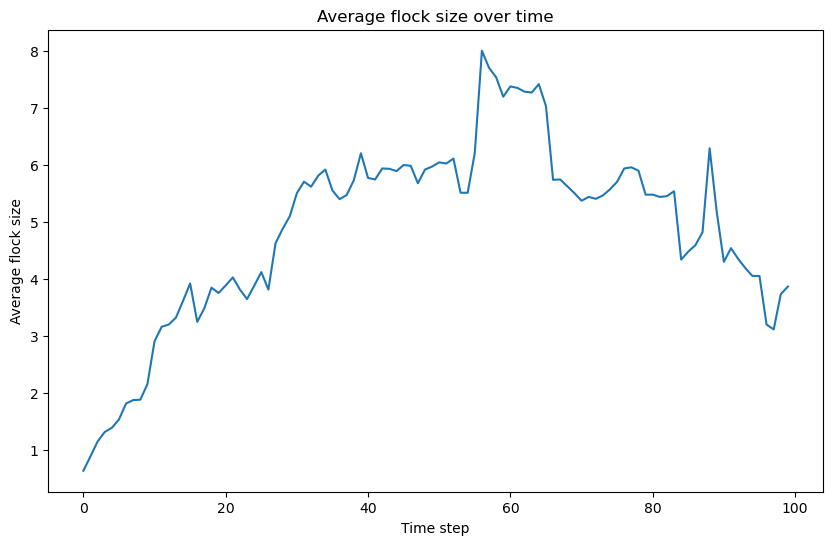

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(Nt), flock_sizes)
plt.xlabel('Time step')
plt.ylabel('Average flock size')
plt.title('Average flock size over time')
plt.show()

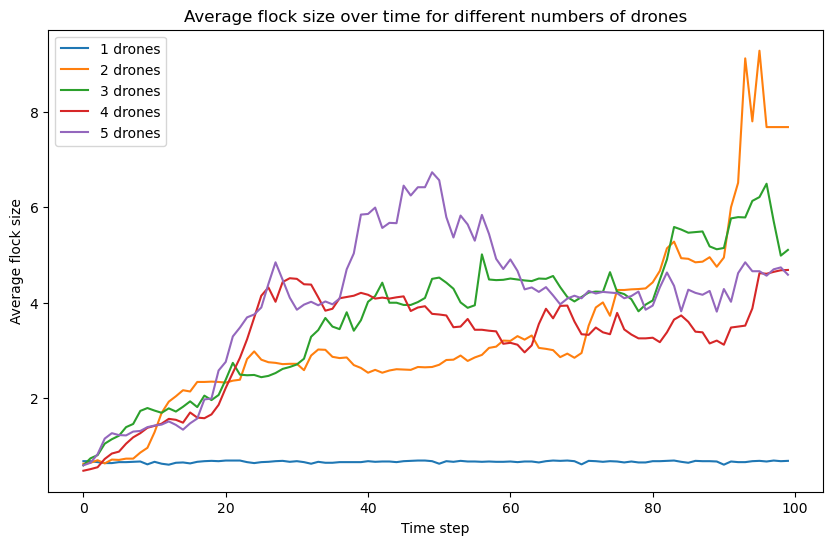

In [27]:
# Define a range of drone numbers
drone_numbers = range(1, 6)

# Initialize a list to store the flock sizes for each number of drones
all_flock_sizes = []

for Nd in drone_numbers:
    # Initialize birds and drones
    x, y, vx, vy, theta = initialize_birds(N, L)
    drone_x, drone_y, drone_vx, drone_vy = initialize_drones(Nd, L)

    # Initialize a list to store the flock sizes for this number of drones
    flock_sizes = []

    for _ in range(Nt):
        drone_x, drone_y, drone_vx, drone_vy = update_drones(drone_x, drone_y, drone_vx, drone_vy, L, vd, dt)
        x, y, vx, vy, stuck_birds = update(x, y, vx, vy, theta, drone_x, drone_y, drone_vx, drone_vy, R**2, eta, N, dt, stuck_birds)
        
        # Calculate the flock size
        flock_size = calculate_flock_size(list(zip(x, y)), R)
        flock_sizes.append(flock_size)

    # Store the flock sizes for this number of drones
    all_flock_sizes.append(flock_sizes)

# Plot the results
plt.figure(figsize=(10, 6))
for Nd, flock_sizes in zip(drone_numbers, all_flock_sizes):
    plt.plot(range(Nt), flock_sizes, label=f'{Nd} drones')
plt.xlabel('Time step')
plt.ylabel('Average flock size')
plt.title('Average flock size over time for different numbers of drones')
plt.legend()
plt.show()